# Battle of the Neighborhoods

## 1) Introduction/ Business Problem

For this capstone project I will assume that a restaurant owner wants to open a branch in another city. As the owner doesn't know the chosen city too well, the city's neighborhoods will be analyzed. Being quite happy with the business so far, the owner tends to choose a neighborhood, that is mostly similar to the one of the first restaurant. This will help to start the new branch with a well-known strategy. 
I will pick a random restaurant from Berlin, Germany, and check for similar neighborhoods in Hamburg, Germany. The neighborhood of the restaurant in Berlin will be explored, as well as all neighborhoods in Hamburg. By clustering Hamburg's neighborhoods, based on venues, I will find similar neighborhoods to the restaurant's place. 
To make a final decision, similar neighborhoods will be analysed with regard to population denstiy and rental prices.

The question to be answered in this case is: "Which location in another city is benefitial to carry over an established restaurant and its business strategy?"


## 2) Data

To get all the required information a list of neighborhoods of the city Hamburg with their specific geographical data is needed. This data can be scraped from the website "https://de.wikipedia.org/wiki/Liste_der_Bezirke_und_Stadtteile_Hamburgs", that also includes the population density. 
The information about the restaurant will be picked manually, as they are given parameters in this scenario.
Additional infomation about Hamburg will be scraped from "https://mietspiegeltabelle.de/mietspiegel-hamburg/" to get the neighborhood's rental prices.

The neighborhood data is mostly used to get information about the nearby venues, which will be found by foursquare. Based on the venues composition clusters will be set, that include the venues of Hamburg and the venues of the original restaurant in Berlin. By clustering the amount of possible neighborhood will be reduced. To make a final decision, the population density and the rental prices of the neighborhoods will be taken into account. 
A high population density will be rated as beneficial, as it grants access to more customers. On the other hand a low rent is preferable to reduce costs of the branch. 

In [152]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
import numpy as np
from sklearn.cluster import KMeans
import folium 
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

### Collecting Neighborhood Data from the city Hamburg

In [153]:
url = 'https://de.wikipedia.org/wiki/Liste_der_Bezirke_und_Stadtteile_Hamburgs'
html_data = requests.get(url)
print(html_data.status_code)
soup = BeautifulSoup(html_data.text, 'lxml')

table_contents = []
table = soup.findAll('table')[1]
n=0
for row in table.findAll('tr')[1:]:
    cell = {}
    elements = row.text.split('\n')
    cell['Neighborhood'] = elements[1]
    cell['Borough'] = elements[5]
    cell['Area'] = elements[7]
    cell['Population'] = elements[9]
    cell['Population density'] = elements[11]
    latitude = elements[13].split(',')[0].split()
    latitude = float(latitude[0][:-1]) + float(latitude[1][:-1])/60 + float(latitude[2][:-1])/3600
    cell['Latitude'] = latitude
    longitude = elements[13].split(',')[1].split()
    longitude = float(longitude[0][:-1]) + float(longitude[1][:-1])/60 + float(longitude[2][:-1])/3600
    cell['Longitude'] = longitude
    
    table_contents.append(cell)

df_hh = pd.DataFrame(table_contents)
df_hh.head()
    

200


,Neighborhood,Borough,Area,Population,Population density,Latitude,Longitude
0,Hamburg-Altstadt,Hamburg-Mitte,"2,4",2350,979,53.550000,10.000000
1,HafenCity,Hamburg-Mitte,"2,2",4925,2239,53.541111,10.000278
2,Neustadt,Hamburg-Mitte,"2,3",12.762,5549,53.551944,9.985556
3,St. Pauli,Hamburg-Mitte,"2,5",22.097,8839,53.556944,9.963889
4,St. Georg,Hamburg-Mitte,"2,4",11.358,4733,53.555000,10.012222


### Collecting rental prices of Hamburg's neighborhoods

In [154]:
url = 'https://mietspiegeltabelle.de/mietspiegel-hamburg/'
html_data = requests.get(url)
print(html_data.status_code)
soup = BeautifulSoup(html_data.text, 'lxml')

table_contents = []
table = soup.find('table')
table

for row in table.findAll('tr')[1:]:
    cell = {}
    elements = row.text.split(' ')
    cell['Neighborhood'] = elements[0]
    cell['Rent'] = elements[1].replace(',', '.')

    
    table_contents.append(cell)

df_hh_price = pd.DataFrame(table_contents)
df_hh_price.head()

200


,Neighborhood,Rent
0,Allermöhe,8.70
1,Alsterdorf,10.72
2,Altengamme,8.00
3,Altenwerder,9.08
4,Altona-Altstadt,10.60


### Explore the neighborhoods of Hamburg

In [155]:
# set foursquare input data
CLIENT_ID = 'W53Z15WG2LD5EQMIEN2TIJRSZLNWNVFB3JWA1M1RJVO32NIB'
CLIENT_SECRET = 'ZLJOQK1UZ345LMLME3ZHDEQD3QFPLSYG2KHXOIMYRNUPN3RD'
VERSION = '20180605'
LIMIT = 100

In [156]:
# function to get venues and put them into a dataframe
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [157]:
hh_venues = getNearbyVenues(df_hh['Neighborhood'], df_hh['Latitude'], df_hh ['Longitude'])
hh_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Hamburg-Altstadt,53.55,10.0,GOOT - Finest Cuts,53.548509,10.000675,Comfort Food Restaurant
1,Hamburg-Altstadt,53.55,10.0,O-ren Ishii,53.548291,9.997890,Vietnamese Restaurant
2,Hamburg-Altstadt,53.55,10.0,Park Hyatt Hamburg,53.550977,10.003158,Hotel
3,Hamburg-Altstadt,53.55,10.0,Thalia Theater,53.552000,9.998338,Theater
4,Hamburg-Altstadt,53.55,10.0,Passage Kino,53.550708,9.998299,Indie Movie Theater


In [158]:
hh_venues.shape

(1507, 7)

In [159]:
print('There are {} unique categories.'.format(len(hh_venues['Venue Category'].unique())))

There are 235 unique categories.


### Explore the restaurant's neighborhood

randomly chosen Restaurant in Berlin. Restaurant 'Luitpold' offers croatian cuisine and is used as a fictional stalkeholder.

In [160]:
address = 'Wegscheider Straße 7, 13587 Berlin'

geolocator = Nominatim(user_agent = 'foursquare_agent')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print( latitude, longitude)

52.5568134 13.2042359


In [161]:
restaurant_venues = getNearbyVenues(['Restaurant Neighborhood'], [latitude], [longitude])
restaurant_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Restaurant Neighborhood,52.556813,13.204236,Luitpold,52.556970,13.203926,Restaurant
1,Restaurant Neighborhood,52.556813,13.204236,H Amorbacher Weg,52.557177,13.207694,Bus Stop
2,Restaurant Neighborhood,52.556813,13.204236,Kaiser's,52.557092,13.208334,Supermarket
3,Restaurant Neighborhood,52.556813,13.204236,ALDI NORD,52.557607,13.208915,Supermarket
4,Restaurant Neighborhood,52.556813,13.204236,TOTAL Tankstelle,52.554240,13.207400,Gas Station


### Preparing the data for analysis

merging of the Hamburg and Berlin Dataframe, one hot encoding and grouping

In [162]:
#Merging of the Neighborhoods of the restaurant and Hamburg's neighborhoods
df_venues = pd.concat([hh_venues, restaurant_venues])
df_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Hamburg-Altstadt,53.550000,10.000000,GOOT - Finest Cuts,53.548509,10.000675,Comfort Food Restaurant
1,Hamburg-Altstadt,53.550000,10.000000,O-ren Ishii,53.548291,9.997890,Vietnamese Restaurant
2,Hamburg-Altstadt,53.550000,10.000000,Park Hyatt Hamburg,53.550977,10.003158,Hotel
3,Hamburg-Altstadt,53.550000,10.000000,Thalia Theater,53.552000,9.998338,Theater
4,Hamburg-Altstadt,53.550000,10.000000,Passage Kino,53.550708,9.998299,Indie Movie Theater
...,...,...,...,...,...,...,...
2,Restaurant Neighborhood,52.556813,13.204236,Kaiser's,52.557092,13.208334,Supermarket
3,Restaurant Neighborhood,52.556813,13.204236,ALDI NORD,52.557607,13.208915,Supermarket
4,Restaurant Neighborhood,52.556813,13.204236,TOTAL Tankstelle,52.554240,13.207400,Gas Station
5,Restaurant Neighborhood,52.556813,13.204236,H Havelschanze,52.554124,13.207755,Bus Stop


In [163]:
# one hot encoding for upcoming cluster processes 
df_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix = "", prefix_sep = "")
df_onehot['City Neighborhood'] = df_venues['Neighborhood']

fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
df_onehot = df_onehot[fixed_columns]
df_onehot.head()

,City Neighborhood,Accessories Store,Afghan Restaurant,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,...,Trattoria/Osteria,Turkish Restaurant,Vape Store,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Video Store,Vietnamese Restaurant,Water Park,Wine Bar,Wine Shop
0,Hamburg-Altstadt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Hamburg-Altstadt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,Hamburg-Altstadt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Hamburg-Altstadt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Hamburg-Altstadt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [164]:
df_grouped = df_onehot.groupby('City Neighborhood').mean().reset_index()
df_grouped.head()

,City Neighborhood,Accessories Store,Afghan Restaurant,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,...,Trattoria/Osteria,Turkish Restaurant,Vape Store,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Video Store,Vietnamese Restaurant,Water Park,Wine Bar,Wine Shop
0,Allermöhe,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
1,Alsterdorf,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.00000,0.0,0.0,0.000000,0.0,0.090909,0.0,0.0,0.0
2,Altengamme,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
3,Altona-Altstadt,0.0,0.0,0.0,0.03125,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.03125,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
4,Altona-Nord,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.038462,...,0.0,0.00000,0.0,0.0,0.038462,0.0,0.000000,0.0,0.0,0.0


### Most common venues

In [165]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [166]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['City Neighborhood'] = df_grouped['City Neighborhood']

for ind in np.arange(df_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,City Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allermöhe,Plaza,Supermarket,Bank,Drugstore,Farmers Market,Lake,Soccer Field,Indoor Play Area,Music Venue,Neighborhood
1,Alsterdorf,Bus Stop,Ice Cream Shop,Pharmacy,Bank,Canal,Doner Restaurant,Metro Station,Diner,Vietnamese Restaurant,Greek Restaurant
2,Altengamme,Stables,Accessories Store,Middle Eastern Restaurant,Modern European Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood
3,Altona-Altstadt,Hotel,Italian Restaurant,Pub,Restaurant,Food & Drink Shop,Furniture / Home Store,Seafood Restaurant,Mexican Restaurant,Nightclub,Café
4,Altona-Nord,Nightclub,Bakery,Brewery,Cultural Center,Bus Stop,French Restaurant,German Restaurant,Shipping Store,Sri Lankan Restaurant,Street Food Gathering


## 3) Data Analysis

### Clustering of neighborhoods based on venues

clustering should show neighborhoods, similar to the neighborhood of the original restaurant

In [167]:
kclusters = 5

df_clustering = df_grouped.drop('City Neighborhood', 1)

kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(df_clustering)

kmeans.labels_[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 2])

In [168]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)


In [169]:
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['City Neighborhood'] == 'Restaurant Neighborhood']

,Cluster Labels,City Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
70,2,Restaurant Neighborhood,Bus Stop,Supermarket,Restaurant,Gas Station,Accessories Store,Paella Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum


The original restaurant is put in Cluster 2. Therefore I can assume that neighborhoods in Hamburg, that also belong to cluster 2 are comparable to the restaurants neighborhood.

In [170]:
# adding the restaurant data to the extracted data of Hamburg 
df_restaurant = pd.DataFrame([['Restaurant Neighborhood', np.nan, np.nan, np.nan, np.nan, latitude, longitude]], columns= df_hh.columns)
df_overall = df_hh.append(df_restaurant, ignore_index = True)

df_merged = df_overall.join(neighborhoods_venues_sorted.set_index('City Neighborhood'), on = 'Neighborhood')
df_merged.head()

,Neighborhood,Borough,Area,Population,Population density,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Hamburg-Altstadt,Hamburg-Mitte,"2,4",2350,979,53.550000,10.000000,0.0,Coffee Shop,Hotel,Vietnamese Restaurant,Burger Joint,Café,Cosmetics Shop,Asian Restaurant,Restaurant,German Restaurant,Candy Store
1,HafenCity,Hamburg-Mitte,"2,2",4925,2239,53.541111,10.000278,0.0,Hotel,Bakery,Italian Restaurant,Bar,Coffee Shop,Bus Stop,Seafood Restaurant,Asian Restaurant,Museum,Park
2,Neustadt,Hamburg-Mitte,"2,3",12.762,5549,53.551944,9.985556,0.0,Hotel,Coffee Shop,Café,Clothing Store,French Restaurant,Restaurant,Bar,Italian Restaurant,Cosmetics Shop,German Restaurant
3,St. Pauli,Hamburg-Mitte,"2,5",22.097,8839,53.556944,9.963889,0.0,Bakery,Bar,Vietnamese Restaurant,Austrian Restaurant,Convenience Store,Bookstore,Sporting Goods Shop,Burrito Place,Soccer Stadium,Shopping Mall
4,St. Georg,Hamburg-Mitte,"2,4",11.358,4733,53.555000,10.012222,0.0,Italian Restaurant,Hotel,Café,Coffee Shop,French Restaurant,Cocktail Bar,Theater,Indian Restaurant,Bar,Bakery


In [171]:
df_merged.dropna(subset=['Cluster Labels'], inplace=True)
df_merged['Cluster Labels'].unique()

array([0., 2., 1., 4., 3.])

In [172]:
# create map
map_clusters = folium.Map(location=[df_hh['Latitude'].mean(), df_hh['Longitude'].mean()], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Neighborhood'], df_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    cluster = int(cluster)
    #print(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [173]:
df_first_cluster = df_merged.loc[df_merged['Cluster Labels'] == 2.0]
df_first_cluster

,Neighborhood,Borough,Area,Population,Population density,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Billbrook,Hamburg-Mitte,"6,1",1740,285,53.527778,10.086111,2.0,Hotel,Bus Stop,Accessories Store,Pakistani Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood
25,Othmarschen,Altona,"6,0",15.737,2623,53.552778,9.894444,2.0,Bus Stop,Health & Beauty Service,German Restaurant,Accessories Store,Pakistani Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue
26,Lurup,Altona,"6,3",36.610,5811,53.593056,9.882778,2.0,Playground,Supermarket,Bus Stop,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood
39,Schnelsen,Eimsbüttel,"9,0",29.604,3289,53.633333,9.916667,2.0,Bus Stop,Supermarket,Bakery,Doner Restaurant,Discount Store,Chinese Restaurant,Fish & Chips Shop,Nightclub,Palace,Neighborhood
41,Stellingen,Eimsbüttel,"5,8",26.683,4601,53.592222,9.928611,2.0,Supermarket,Mediterranean Restaurant,Gym / Fitness Center,Electronics Store,Convenience Store,Multiplex,Museum,Music Venue,Pakistani Restaurant,Neighborhood
53,Fuhlsbüttel,Hamburg-Nord,"7,8",13.441,1723,53.634444,10.016111,2.0,Indian Restaurant,Sports Club,Furniture / Home Store,Supermarket,Bus Stop,Middle Eastern Restaurant,Modern European Restaurant,Motorcycle Shop,Movie Theater,Multiplex
58,Jenfeld,Wandsbek,"5,0",27.125,5425,53.572222,10.136111,2.0,Supermarket,Vietnamese Restaurant,Bus Stop,German Restaurant,Accessories Store,Paella Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum
62,Steilshoop,Wandsbek,"2,5",19.941,7976,53.610278,10.059167,2.0,Supermarket,Bus Stop,Shopping Mall,Gym / Fitness Center,Accessories Store,Paella Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum
65,Poppenbüttel,Wandsbek,"8,1",23.901,2951,53.659167,10.084722,2.0,Supermarket,Restaurant,Ice Cream Shop,German Restaurant,Cosmetics Shop,Park,Bus Stop,Middle Eastern Restaurant,Hotel,Japanese Restaurant
67,Lemsahl-Mellingstedt,Wandsbek,"8,0",6852,857,53.690000,10.096389,2.0,Supermarket,Wine Shop,French Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue


In [174]:
df_first_cluster.shape

(18, 18)

Based on the clustering, there are 17 potential neighborhoods in Hamburg for the new branch. In order to get a more specific list of options the first cluster will be clustered again.

### Second cluster for further refinement

Same method as in the first cluster, but the list of possible neighborhoods is reduced to the ones in the first cluster.

In [175]:
# reducing the grouped frame to neighborhoods included in the first cluster
df_grouped2 = df_grouped.loc[df_grouped['City Neighborhood'].isin(df_first_cluster['Neighborhood']).tolist()]
df_grouped2.head()

,City Neighborhood,Accessories Store,Afghan Restaurant,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,...,Trattoria/Osteria,Turkish Restaurant,Vape Store,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Video Store,Vietnamese Restaurant,Water Park,Wine Bar,Wine Shop
9,Bergstedt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,Billbrook,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,Eißendorf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,Fuhlsbüttel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45,Jenfeld,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0


In [176]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted2 = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted2['City Neighborhood'] = df_grouped2['City Neighborhood']

for ind in np.arange(df_grouped2.shape[0]):
    neighborhoods_venues_sorted2.iloc[ind, 1:] = return_most_common_venues(df_grouped2.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted2.head()

,City Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Bergstedt,Supermarket,Bus Stop,Gym / Fitness Center,Bakery,Department Store,Other Nightlife,Organic Grocery,Optical Shop,Nightclub,Accessories Store
10,Billbrook,Hotel,Bus Stop,Accessories Store,Pakistani Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood
23,Eißendorf,Supermarket,Bakery,Greek Restaurant,Accessories Store,Pakistani Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue
28,Fuhlsbüttel,Indian Restaurant,Sports Club,Furniture / Home Store,Supermarket,Bus Stop,Middle Eastern Restaurant,Modern European Restaurant,Motorcycle Shop,Movie Theater,Multiplex
45,Jenfeld,Supermarket,Vietnamese Restaurant,Bus Stop,German Restaurant,Accessories Store,Paella Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum


In [177]:
kclusters = 5
df_clustering = df_grouped2.drop('City Neighborhood', 1)
kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(df_clustering)
neighborhoods_venues_sorted2.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted2.head()

,Cluster Labels,City Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,2,Bergstedt,Supermarket,Bus Stop,Gym / Fitness Center,Bakery,Department Store,Other Nightlife,Organic Grocery,Optical Shop,Nightclub,Accessories Store
10,4,Billbrook,Hotel,Bus Stop,Accessories Store,Pakistani Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood
23,2,Eißendorf,Supermarket,Bakery,Greek Restaurant,Accessories Store,Pakistani Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue
28,1,Fuhlsbüttel,Indian Restaurant,Sports Club,Furniture / Home Store,Supermarket,Bus Stop,Middle Eastern Restaurant,Modern European Restaurant,Motorcycle Shop,Movie Theater,Multiplex
45,1,Jenfeld,Supermarket,Vietnamese Restaurant,Bus Stop,German Restaurant,Accessories Store,Paella Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum


In [178]:
neighborhoods_venues_sorted2.loc[neighborhoods_venues_sorted['City Neighborhood'] == 'Restaurant Neighborhood']

,Cluster Labels,City Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
70,1,Restaurant Neighborhood,Bus Stop,Supermarket,Restaurant,Gas Station,Accessories Store,Paella Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum


In [179]:
df_overall2 = df_overall.loc[df_overall['Neighborhood'].isin(df_first_cluster['Neighborhood']).tolist()]
df_merged2 = df_overall2.join(neighborhoods_venues_sorted2.set_index('City Neighborhood'), on = 'Neighborhood')
df_merged2.head()

,Neighborhood,Borough,Area,Population,Population density,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Billbrook,Hamburg-Mitte,"6,1",1740,285,53.527778,10.086111,4,Hotel,Bus Stop,Accessories Store,Pakistani Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood
25,Othmarschen,Altona,"6,0",15.737,2623,53.552778,9.894444,4,Bus Stop,Health & Beauty Service,German Restaurant,Accessories Store,Pakistani Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue
26,Lurup,Altona,"6,3",36.610,5811,53.593056,9.882778,1,Playground,Supermarket,Bus Stop,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood
39,Schnelsen,Eimsbüttel,"9,0",29.604,3289,53.633333,9.916667,1,Bus Stop,Supermarket,Bakery,Doner Restaurant,Discount Store,Chinese Restaurant,Fish & Chips Shop,Nightclub,Palace,Neighborhood
41,Stellingen,Eimsbüttel,"5,8",26.683,4601,53.592222,9.928611,2,Supermarket,Mediterranean Restaurant,Gym / Fitness Center,Electronics Store,Convenience Store,Multiplex,Museum,Music Venue,Pakistani Restaurant,Neighborhood


In [180]:
df_merged2.dropna(subset=['Cluster Labels'], inplace=True)
df_merged2['Cluster Labels'].unique()

array([4, 1, 2, 0, 3])

In [181]:
# create map
map_clusters = folium.Map(location=[df_hh['Latitude'].mean(), df_hh['Longitude'].mean()], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged2['Latitude'], df_merged2['Longitude'], df_merged2['Neighborhood'], df_merged2['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    cluster = int(cluster)
    #print(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [182]:
df_second_cluster = df_merged2.loc[df_merged2['Cluster Labels'] == 1.0]
###df_second_cluster

### Investigation of second cluster

With the second cluster the amount of possible neighborhoods is reduced to 6. These 6 neighborhoods will be compared with respect to the possible amount of customers based on the population density and the restaurant's costs based on the local rental prices.

In [183]:
# The Dataframe with the rental prices is reduced to the neighborhoods of the second cluster and merged with the dataframe of the second cluster
df_prices_second_cluster = df_hh_price.loc[df_hh_price['Neighborhood'].isin(df_second_cluster['Neighborhood']).tolist()]
df_second_cluster = df_second_cluster.merge(df_prices_second_cluster, on = 'Neighborhood')
df_second_cluster.shape

(6, 19)

In [184]:
df_second_cluster = df_second_cluster.astype({'Population density' : 'int64', 
                                              'Cluster Labels' : 'int64', 
                                              'Rent' : 'float64'})
df_second_cluster.dtypes

Neighborhood               object
Borough                    object
Area                       object
Population                 object
Population density          int64
Latitude                  float64
Longitude                 float64
Cluster Labels              int64
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
Rent                      float64
dtype: object

Text(0, 0.5, '')

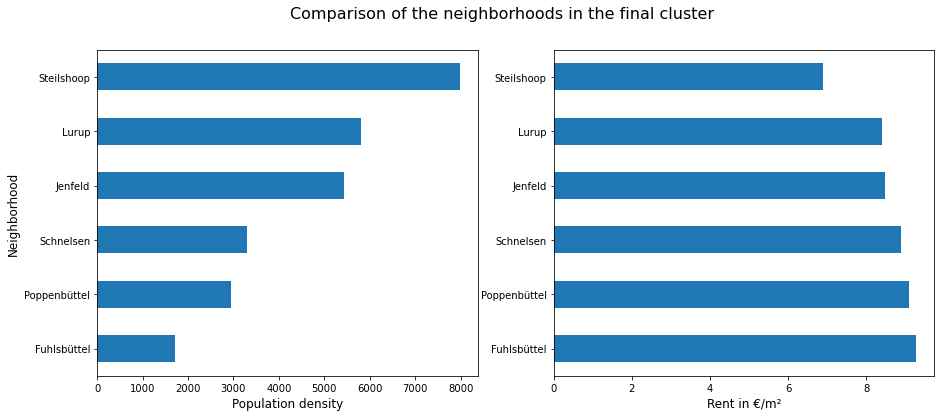

In [185]:
df_plot = df_second_cluster.sort_values(by='Population density')

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 6))
df_plot.plot.barh(x = 'Neighborhood', y = 'Population density', ax = ax[0], legend = False)
df_plot.plot.barh(x = 'Neighborhood', y = 'Rent', ax = ax[1], legend = False)

fig.suptitle('Comparison of the neighborhoods in the final cluster', fontsize = 16)
ax[0].set_xlabel('Population density', fontsize = 12)
ax[1].set_xlabel('Rent in €/m²', fontsize = 12)
ax[0].set_ylabel('Neighborhood', fontsize = 12)
ax[1].set_ylabel('')

### Final decision

Based on the data analysis "Steilshoop" seems to be the best location for the new branch. This neighborhood offers a high similarity based on venues to the neighborhood of the restaurant in Berlin. The high population density and the low rental prices are benefitial in terms of customer acquisition and costs